In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import re
import numpy as np

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (8,8) #setting the image size

### Reading the csv file in the dataset

In [4]:
dataset_df = pd.read_csv("/Users/neha/Documents/Projects for Resume/Sentiment Analysis on United Airlines/reviews.csv",error_bad_lines=False)

b'Skipping line 4846: expected 4 fields, saw 7\n'


### Checking the first 20 rows of the dataset

In [5]:
dataset_df.head()

,Date,Rating,Title,Reviews
0,review Today,10,RUINED MY WEDDING,United cancelled my and my wedding guests flig...
1,review Today,10,Changed Flight Twice,United Airlines changed my flight twice. First...
2,review Yesterday,10,#1 WORST AIRLINES IN THE WORLD!!!!,Booked a flight many months ago sitting next t...
3,review Yesterday,10,Worst travel experience of my life,I was on flight UA 1015 from Cancun to Houston...
4,review Yesterday,10,"Terrible, don’t trust or depend on United!","Don’t fly with United, they are unreasonable a..."


### Lets check the shape of the dataset

In [6]:
dataset_df.shape

(10000, 4)

 - #### There are 10000 rows and 4 columns excluding the header

### Checking for null values

In [7]:
dataset_df.isnull().sum()

Date       0
Rating     0
Title      2
Reviews    0
dtype: int64

- #### There are 2 null values in Title field.

## Checking for duplicate row

In [8]:
dataset_df.duplicated().sum()

0

- #### There is no duplicate data

## Data Cleaning

### The 10 in the rating column is basically 1 star. Lets change it to the appropriate type

In [9]:
dataset_df['Ratings']= dataset_df['Rating'].astype(str).str[0]

In [10]:
dataset_df['Ratings']

0       1
1       1
2       1
3       1
4       1
       ..
9995    5
9996    1
9997    5
9998    5
9999    3
Name: Ratings, Length: 10000, dtype: object

### Lets check the dataframe

In [11]:
dataset_df.tail()

,Date,Rating,Title,Reviews,Ratings
9995,Apr-19,50,Great flight,"First flight in the 787 Dreamliner, very comfo...",5
9996,Apr-19,10,Typical air-travel nightmare,"As we drove to the airport, a text alerted us ...",1
9997,Apr-19,50,Rapid City - Denver - Dulles - Ottawa,Early morning start from Rapid with a comfy la...,5
9998,Apr-19,50,Quiet and plesent flight,Had a Saturday noon flight. Very friendly crew...,5
9999,Apr-19,30,Paid for extended leg room and it was not that...,"We had 4 legs on this trip, the 2nd one from N...",3


The dataset includes data from Apr 2019 to April 11 2021

### Lets drop the rating column as we no longer need it.

In [12]:
dataset_df.drop(columns = 'Rating',inplace=True)

### Checking all the columns datatype

In [13]:
dataset_df.dtypes

Date       object
Title      object
Reviews    object
Ratings    object
dtype: object

### Changing rating to numeric

In [14]:
dataset_df['Ratings'] = pd.to_numeric(dataset_df['Ratings'])

In [15]:
dataset_df.dtypes

Date       object
Title      object
Reviews    object
Ratings     int64
dtype: object

### Changing date to Dateformat

In [16]:
dataset_df['Date'] = dataset_df['Date'].replace(['review Today','review Yesterday','9-Apr','8-Apr','7-Apr','6-Apr','5-Apr','4-Apr','3-Apr','2-Apr','1-Apr'],'Apr-21')

In [17]:
dataset_df.head()

,Date,Title,Reviews,Ratings
0,Apr-21,RUINED MY WEDDING,United cancelled my and my wedding guests flig...,1
1,Apr-21,Changed Flight Twice,United Airlines changed my flight twice. First...,1
2,Apr-21,#1 WORST AIRLINES IN THE WORLD!!!!,Booked a flight many months ago sitting next t...,1
3,Apr-21,Worst travel experience of my life,I was on flight UA 1015 from Cancun to Houston...,1
4,Apr-21,"Terrible, don’t trust or depend on United!","Don’t fly with United, they are unreasonable a...",1


#### Comparing it with the earlier result we can see that the date is changed appropriately.

## Exploratory Data Analysis

### Checking the numbers of reviews per month

In [18]:
dataset_df['Date'] = pd.to_datetime(dataset_df['Date'], format='%b-%y')

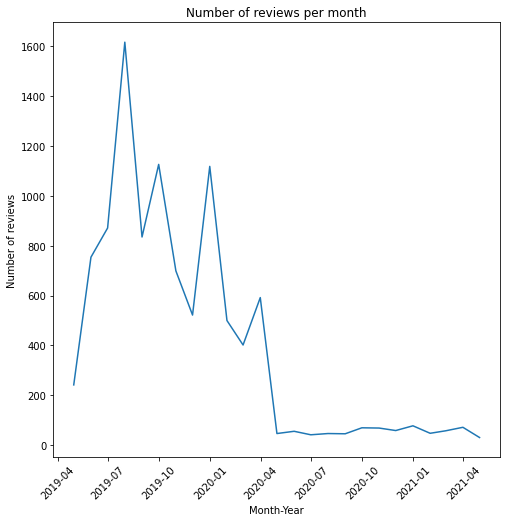

In [19]:
df = dataset_df.set_index('Date')
plt.plot(df['Reviews'].resample('M').count()) # to count all data belonging to particular month together
plt.xlabel('Month-Year')
plt.ylabel('Number of reviews')
plt.title('Number of reviews per month')
plt.xticks(rotation=45)
plt.show()

- ### The reviews were more during the pre COVID era almost above 1000 in December 2020. As soon as the pandemic started the reviews started declining almost less than 200 a month.

### Counting each Rating

In [20]:
df.Ratings.value_counts()

4    2456
1    2440
5    2409
3    1555
2    1140
Name: Ratings, dtype: int64

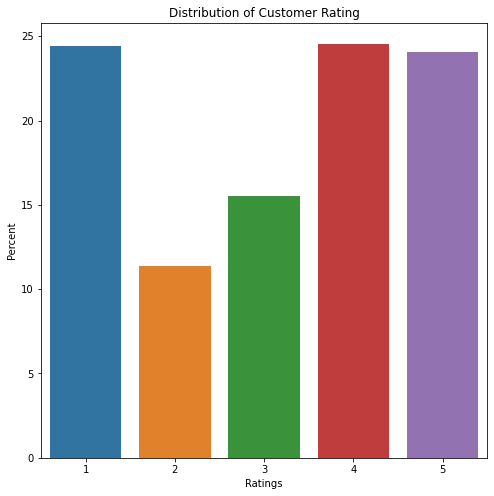

In [21]:
ax = sns.barplot(data=df, x='Ratings', y='Ratings', estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")
plt.title('Distribution of Customer Rating')
plt.show()

- ### United Airlines has got equal number of 1 and 4 rating followed by 5 rating.

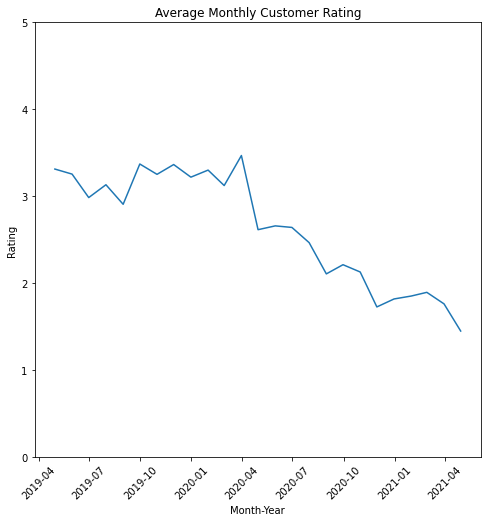

In [22]:
plt.plot(df['Ratings'].resample('M').mean())  # all data belonging to particular month together will be averaged
plt.xlabel('Month-Year')
plt.ylabel('Rating')
plt.title('Average Monthly Customer Rating')
plt.ylim(0,5)
plt.xticks(rotation=45)
plt.show()

- ### As the pandemic started we can see the decline in the rating. The rating is always below 3.

##  Text Preprocessing

In [23]:
df.dtypes

Title      object
Reviews    object
Ratings     int64
dtype: object

### Lower Case

In [24]:
df['Reviews'] = df['Reviews'].str.lower()
df['Reviews'].head()

Date
2021-04-01    united cancelled my and my wedding guests flig...
2021-04-01    united airlines changed my flight twice. first...
2021-04-01    booked a flight many months ago sitting next t...
2021-04-01    i was on flight ua 1015 from cancun to houston...
2021-04-01    don’t fly with united, they are unreasonable a...
Name: Reviews, dtype: object

### Tokenization

In [25]:
import nltk
import string
def identify_tokens(row):
    review = row['Reviews']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation using isalpha function)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

df['Reviews'] = df.apply(identify_tokens, axis=1)
df['Reviews'].tail()

Date
2019-04-01    [first, flight, in, the, dreamliner, very, com...
2019-04-01    [as, we, drove, to, the, airport, a, text, ale...
2019-04-01    [early, morning, start, from, rapid, with, a, ...
2019-04-01    [had, a, saturday, noon, flight, very, friendl...
2019-04-01    [we, had, legs, on, this, trip, the, one, from...
Name: Reviews, dtype: object

## Lemmatization

In [26]:
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatization(row):
    my_list = row['Reviews']
    lemmatized_list = [lemmatizer.lemmatize(word) for word in my_list]
    return (lemmatized_list)

df['Reviews'] = df.apply(lemmatization, axis=1)
df['Reviews'].tail()

Date
2019-04-01    [first, flight, in, the, dreamliner, very, com...
2019-04-01    [a, we, drove, to, the, airport, a, text, aler...
2019-04-01    [early, morning, start, from, rapid, with, a, ...
2019-04-01    [had, a, saturday, noon, flight, very, friendl...
2019-04-01    [we, had, leg, on, this, trip, the, one, from,...
Name: Reviews, dtype: object

### Removing Stop word

In [27]:
from nltk.corpus import stopwords
stops = set(stopwords.words("english")+ ['united','airline','flight','plane','united airlines','wa'])                  

def remove_stops(row):
    my_list = row['Reviews']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)

df['Reviews'] = df.apply(remove_stops, axis=1)
df.Reviews.head()

Date
2021-04-01    [cancelled, wedding, guest, day, wedding, arub...
2021-04-01    [changed, twice, first, changed, mere, week, s...
2021-04-01    [booked, many, month, ago, sitting, next, wife...
2021-04-01    [ua, cancun, houston, scheduled, depart, hour,...
2021-04-01    [fly, unreasonable, inconsiderate, others, zer...
Name: Reviews, dtype: object

## Rejoin words

In [28]:
def rejoin_words(row):
    my_list = row['Reviews']
    joined_words = ( " ".join(my_list))
    return joined_words

df['Reviews'] = df.apply(rejoin_words, axis=1)

### Word Cloud

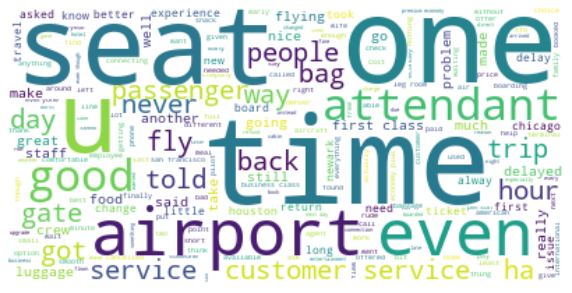

In [29]:
reviews_str = df.Reviews.str.cat()
wordcloud = WordCloud(background_color='white').generate(reviews_str)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
# Now let's split the data into Negative (Score is 1 or 2) and Positive (4 or 5) Reviews.
negative_reviews = df[df['Ratings'].isin([1,2]) ]
positive_reviews = df[df['Ratings'].isin([4,5]) ]
# Transform to single string
negative_reviews_str = negative_reviews.Reviews.str.cat()
positive_reviews_str = positive_reviews.Reviews.str.cat()

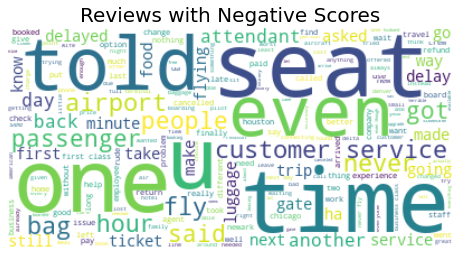

In [31]:
wordcloud_negative = WordCloud(background_color='white').generate(negative_reviews_str)
wordcloud_positive = WordCloud(background_color='white').generate(positive_reviews_str)
# Plot
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(211)
ax1.imshow(wordcloud_negative,interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Reviews with Negative Scores',fontsize=20)
plt.show()

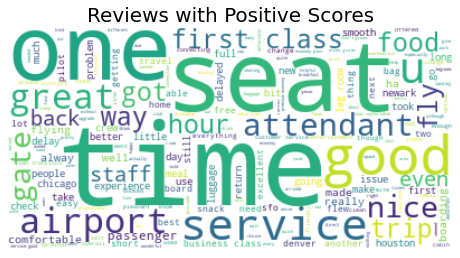

In [32]:
fig = plt.figure(figsize=(8,10))
ax2 = fig.add_subplot(212)
ax2.imshow(wordcloud_positive,interpolation='bilinear')
ax2.axis("off")
ax2.set_title('Reviews with Positive Scores',fontsize=20)
plt.show()

### Count Vectorizer - Bigrams

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(ngram_range=(2,2)) #Only bigrams
bigrams = vect.fit_transform(df['Reviews'])
# Creating a dataframe
bigram_df = pd.DataFrame(bigrams.toarray(), columns=vect.get_feature_names()) #get_feature_names() - gets unique words present in Reviews columns
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'Frequency']
bigram_frequency = bigram_frequency.sort_values(by='Frequency', ascending=False).head(20)

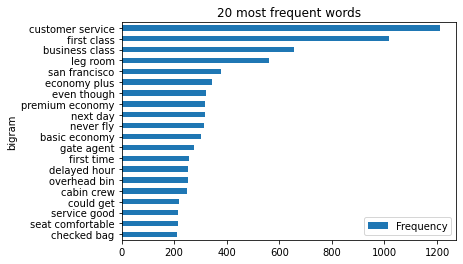

In [57]:
bigram_frequency.sort_values('Frequency', ascending=True).plot(x='bigram', y='Frequency',kind='barh')
plt.title("20 most frequent words")
plt.show()

- #### Customer service seems to be more popular of United Airlines. Followed by First Class, Business Class, Leg room

## Sentiment Analysis using Vader

In [35]:
# Load SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# Instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
# Generate sentiment scores
sentiment_scores = df['Reviews'].apply(sid.polarity_scores)
sentiment = sentiment_scores.apply(lambda x: x['compound'])
monthly_sentiment = sentiment.resample('M').mean()

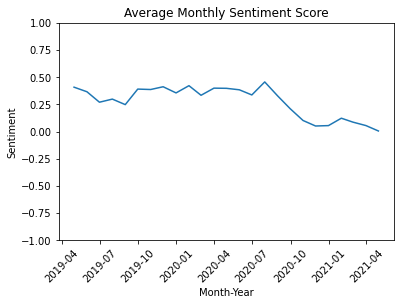

In [58]:
%matplotlib inline
plt.plot(monthly_sentiment)  # all data belonging to particular month together will be averaged
plt.xlabel('Month-Year')
plt.ylabel('Sentiment')
plt.title('Average Monthly Sentiment Score')
plt.ylim(-1,1)
plt.xticks(rotation=45)
plt.show()

Generally, the sentiment for this airlines is positive and we can notice there is a decreasing trend especially after the pandemic.

### Analysis to check if the model predicts accurately

In [37]:
review = "The flight was amazing"
sid.polarity_scores(review)

{'neg': 0.0, 'neu': 0.441, 'pos': 0.559, 'compound': 0.5859}

In [38]:
review = "The flight was delayed for a longer time."
sid.polarity_scores(review)

{'neg': 0.241, 'neu': 0.759, 'pos': 0.0, 'compound': -0.2263}

### Classification Algorithm

- #### First, I labeled the positive reviews as “1” (with rating of four or five) and negative reviews as “0” (with rating of one or two). Following is the code for the same. We will exclude the 3 rating as we consider it as neutral.

In [39]:
df=df[df.Ratings != 3]
pd.set_option('mode.chained_assignment', None)
df["Labels"] = df["Ratings"].apply(lambda x: 1 if x < 3  else 0) # positive as 0 and negative as 1
df = df.drop("Ratings",axis=1)

df.head()

,Title,Reviews,Labels
Date,,,
2021-04-01,RUINED MY WEDDING,cancelled wedding guest day wedding aruba choo...,1
2021-04-01,Changed Flight Twice,changed twice first changed mere week schedule...,1
2021-04-01,#1 WORST AIRLINES IN THE WORLD!!!!,booked many month ago sitting next wife seat r...,1
2021-04-01,Worst travel experience of my life,ua cancun houston scheduled depart hour behind...,1
2021-04-01,"Terrible, don’t trust or depend on United!",fly unreasonable inconsiderate others zero res...,1


#### Positive Reviews Count and Percentage

In [40]:
value_count=df['Labels'].value_counts()
count_1=value_count[1]
count_1


3580

In [41]:
count_1/len(df)

0.42391947898164595

#### Negative Reviews and Percentage

In [42]:
count_0=value_count[0]
count_0


4865

In [43]:
count_0/len(df)

0.576080521018354

#### More number of negative reviews

## Bag of Word

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# vectorization
vect = CountVectorizer(max_features=100) #max_features will take into account the top 100 features and drop the rest
vect.fit(df.Reviews)
X = vect.transform(df.Reviews)
X_df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names())
# Define the vector of targets and matrix of features
y = df.Labels
X = X_df
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

 ## Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression().fit(X_train, y_train)
y_pred_lg = log_reg.predict(X_test)
# find the most informative words
log_odds = log_reg.coef_[0]
coeff = pd.DataFrame(log_odds, X.columns, columns=['coef'])\
            .sort_values(by='coef', ascending=False)
coeff.head()


,coef
never,1.264621
ever,0.973633
customer,0.874703
told,0.782885
another,0.642508


In [46]:
score = log_reg.score(X_test, y_test)
print('Test Score', score)


Test Score 0.8141278610891871


In [47]:
log_reg.classes_

array([0, 1])

In [48]:
test_review = vect.transform(["I did not enjoy the food or the service"])
log_reg.predict_proba(test_review)

array([[0.65639404, 0.34360596]])

### Naive Baiyes

In [49]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
pred = nb_classifier.predict(X_test)

In [50]:
score = nb_classifier.score(X_test, y_test)
print('Test Score', score)

Test Score 0.8082083662194159


## TFIDF

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(df['Reviews'])
X_new_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
# Define the vector of targets and matrix of features
y = df.Labels
X = X_new_df
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


## Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression().fit(X_train, y_train)
y_pred_lg = log_reg.predict(X_test)
# find the most informative words
log_odds = log_reg.coef_[0]
coeff = pd.DataFrame(log_odds, X.columns, columns=['coef'])\
            .sort_values(by='coef', ascending=False)
coeff.head()


,coef
never,4.684185
rude,3.879620
worst,3.768209
hour,3.698132
terrible,3.360882


In [53]:
score = log_reg.score(X_test, y_test)
print('Test Score', score)

Test Score 0.89344909234412


## Naive Baiyes

In [54]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
pred = nb_classifier.predict(X_test)

In [55]:
score = nb_classifier.score(X_test, y_test)
print('Test Score', score)

Test Score 0.8752959747434885
